---
<img align="left" width="75" height="95"    src="https://upload.wikimedia.org/wikipedia/en/c/c8/University_of_the_Punjab_logo.png"> 
<h1 align="center">Digital Image Processing</h1>
<h1 align="center">HomeWork 3</h1>
<h3 align="center">MSDSF21M005 Muhammad Tahir</h3>



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

---
<h1 align="center">Butterworth Notch Rject Filter</h1>

Notch reject filters are easily constructed as products of highpass filters whose centers have been translated to the center of the notches
Where HNRplus[u,v] and HNRneg[u,v] are highpass filters whose centers are at (uk,vk) and (-uk,-vk).
The centers at (uk,vk) and (-uk,-vk) are specified with respect to the center of the frequency rectangle, (M/2,N/2).
Distances can be calculated using D_uv and D_muv

In [19]:
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.ones((P, Q))
    HNRplus= np.ones((P,Q))
    HNRneg= np.ones((P,Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            
            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                HNRplus[u,v]=1/(1+(d0/D_uv)**16);
                HNRneg[u,v]=1/(1+(d0/D_muv)**16);
                H[u,v]=HNRplus[u,v]*HNRneg[u,v]
    
    return H

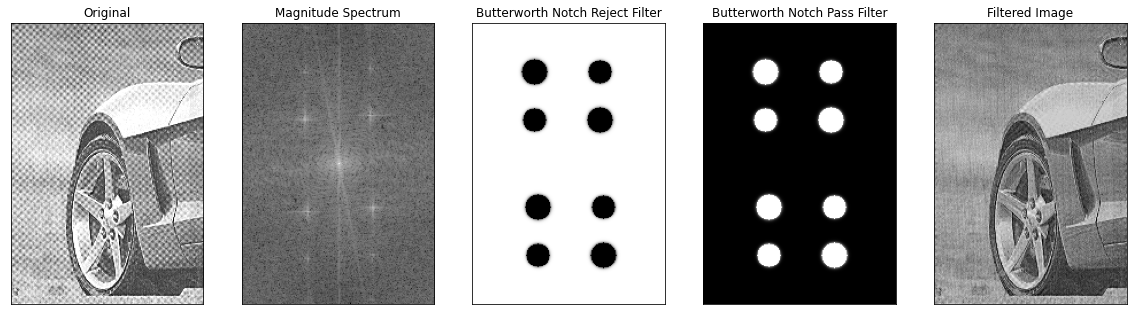

In [20]:
img = cv2.imread('Img-1.tif', 0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

img_shape = img.shape

H1 = notch_reject_filter(img_shape, 10, 38, 30)
H2 = notch_reject_filter(img_shape, 11, -38, 27)
H3 = notch_reject_filter(img_shape, 11, 80, 30)
H4 = notch_reject_filter(img_shape, 10, -80, 27)



NotchFilter = H1*H2*H3*H4
NotchRejectCenter = fshift * NotchFilter 
NotchReject = np.fft.ifftshift(NotchRejectCenter)

NotchPass=1-NotchFilter
# Compute the inverse DFT of the result

inverse_NotchReject = np.fft.ifft2(NotchReject)  

Filtered_Image = np.abs(inverse_NotchReject)

Notch_Regect_Filter=magnitude_spectrum*NotchFilter



f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.subplot(2,5,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,5,2),plt.imshow(magnitude_spectrum,cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(2,5,3),plt.imshow(NotchFilter, "gray") 
plt.title("Butterworth Notch Reject Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,4),plt.imshow(NotchPass,cmap="gray") 
plt.title("Butterworth Notch Pass Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,5),plt.imshow(Filtered_Image,cmap="gray") 
plt.title("Filtered Image"),plt.xticks([]), plt.yticks([])


plt.show()

---
<h1 align="center">Butterworth Band Rject Filter</h1>

Bandreject filters can, in general, be easily constructed using the same concepts as described for other filters.
- D(u,v) is the distance from the center of the frequency rectangle
- D0 is the radial center of the band of interest
- W is the width of the band of interest

In [21]:
def bandreject_filter(shape, d0=160, w=20, n=4):

    P, Q = shape
    # Initialize filter with ones
    H = np.ones((P, Q))
    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)
            # Define bandreject transfer funtion for each filter type
            if D_uv == d0: # To avoid dividing by zero
                H[u, v] = 0
            else:
                H[u, v] = 1/(1 + ((D_uv*w)/(D_uv**2 - d0**2))**(2*n))

    return H

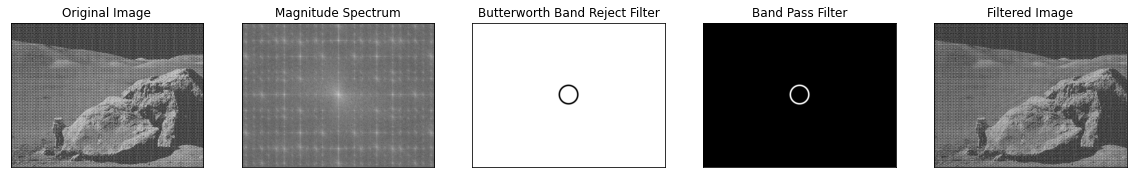

In [52]:
img = cv2.imread('Img-2.tif', 0)
M, N = img.shape
P = 2*M
Q = 2*N

# Take the fourier transform of the image, with padding to shape P X Q
F = np.fft.fft2(img, s=(P,Q))

# Shift the low frequencies to the center.
F = np.fft.fftshift(F)

# Get power spectrum of the image
pow_spec = np.abs(F)**2


# H = notch_reject_filter(F.shape, d0, n, u_k, v_k)
H_1 = bandreject_filter(F.shape, 60, 10, 4)
H_2=H_1
# Form product of image with filter
G = F * H_2

# Shift frequencies back
G = np.fft.ifftshift(G)

# Inverse fourier transform to get output image in spatial domain
G = np.fft.ifft2(G)

# Get real values
G = np.abs(G)

# Extract M x N image from top left quadrant
G = G[0:M, 0:N]
BandPass=1-H_2

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(25)
plt.subplot(2,5,1),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])


plt.subplot(2,5,2),plt.imshow(np.log(pow_spec),cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(2,5,3),plt.imshow(H_2, "gray") 
plt.title("Butterworth Band Reject Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,4),plt.imshow(BandPass, "gray") 
plt.title("Band Pass Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,5,5),plt.imshow(G,cmap="gray") 
plt.title("Filtered Image"),plt.xticks([]), plt.yticks([])


plt.show()